GAN(Generative Adversarial Networks) is an architecture for training generative model.

# Table of Contents

```
0. Introduction | [In 1] ~

1. MNIST Handwritten Digit Dataset | [In 4] ~

2. Define and Train the Discriminator Model | [In 6] ~

3. Define the Generator Model | [In 15] ~

4. Train the Generator Model | [In 21] ~
```

# 0. Introduction

In [1]:
import tensorflow as tf
print("GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

GPUs Available:  1


In [2]:
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)


In [3]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


**Dataset**  
- MNIST

**Environment**
- macOS `x86`cpu

**Framework**  
- TensorFlow: Version `2.10.0`

**Dependencies**  
- Python: Version `3.9.18`
- Numpy: Version `1.26.4`
- Pandas: Version `2.2.2`
- Matplotlib: Version `3.9.2`
- scikit-learn: Version `1.5.1`

**Purpose**
- **Generator**  
  Input: 원본(real) MNIST 데이터셋에 대한 latent space  
  Output: 원본 MNIST와 유사하게 생성해낸 fake MNIST  
  Task: generate

- **Discriminator**  
  Input: Generator가 생성해 낸 fake MNIST(Discriminator는 아직 fake or real 여부를 모른다)  
  Output: Input에 대한 fake or real 여부  
  Task: binary classification

**References**
- [How to Develop a GAN for Generating MNIST Handwritten Digits - MachineLearningMastery.com](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/)


# 1. MNIST Handwritten Digit Dataset

In [4]:
# 70,000 small square 28x28 pixel grayscale images of handwritten single digits between 0 and 9.
from keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data() # 60K examples for training, 10K examples for test
print(f'X_train.shape {X_train.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'X_test.shape  {X_test.shape}')
print(f'y_test.shape  {y_test.shape}')

X_train.shape (60000, 28, 28)
y_train.shape (60000,)
X_test.shape  (10000, 28, 28)
y_test.shape  (10000,)


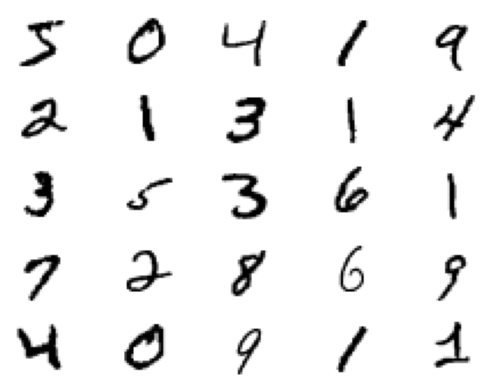

In [5]:
# Plot of the First 25 Handwritten Digits From the MNIST Dataset.
from keras.datasets.mnist import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(25):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

# 2. Define and Train the Discriminator Model

**Discriminator**  
- Input:  Image with one channel(grayscale) and 28x28 pixels with pixel values in [0, 1]  
  &emsp;&emsp;&emsp;ㄴ generated by Generator, but Discriminator don't know.  
  &emsp;&emsp;&emsp;ㄴ 단, 초기 훈련은 Generator가 생성하지 않은 randomly noise로 진행
- Output: Binary Classification(real or fake)
- Label:  1(Real MNIST Dataset Examples), 0(Fake generated by Generator)

**How to Train the Discriminator**  
training with real samples(1) and randomly generated samples(0)

In [6]:
# example of defining the discriminator model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

In [7]:
# example of training the discriminator model on real and random mnist images
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randn
from numpy.random import randint
from numpy import vstack
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU

In [8]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential(name='Discriminator')
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [9]:
# define model
model_d = define_discriminator()
# summarize the model
model_d.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)            

In [10]:
# the label 1 samples for Discriminator - Load
def load_real_samples():
    (X, _), (_, _) = load_data()     # (28, 28)

    X = X.reshape(60000, 28, 28, 1)
    print(f'X.shape {X.shape}')      # (28, 28 ,1) for Conv2D
    X = X.astype('float32')          # int -> float
    X = X / 255.0                    # [0, 255] -> [0, 1]
    
    return X

In [11]:
# Label 1 samples for Discriminator - Generate
# 엄밀히 말하자면 generate보다는 choose에 가까움. 위에서 로드한 데이터 중에서 일부만 뽑음.
def generate_real_samples(dataset, n_samples):
    # choose random instances from loaded real samples
    idx = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[idx]
    # labels for real samples (1)
    y = ones((n_samples, 1))

    return X, y

In [12]:
# label 0 samples for Discriminator - Randomly generate
# Discriminator model의 초기 훈련은 Generator model이 생성해 낸 fake samples가 아니라,
# 완전한 randomly noise인 fake samples로 진행함.
def generate_fake_samples(n_samples):
    # generate uniform random numbers in [0, 1]
    X = rand(28*28*n_samples)
    # reshape for Conv2D
    X = X.reshape((n_samples, 28, 28, 1))
    # labels for fake samples (0)
    y = zeros((n_samples, 1))

    return X, y

In [13]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    '''
    Discriminator model에 대해서 
    각 iteration마다 128개의 real samples, 128개의 fake samples에 대해서 
    real or fake를 분류하는 훈련을 하도록 하는 함수
    '''
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [14]:
dataset = load_real_samples()
train_discriminator(model_d, dataset)

# fake samples가 아직은 randomly noise이기 때문에 분류가 매우 쉽다.

X.shape (60000, 28, 28, 1)
>1 real=81% fake=5%
>2 real=86% fake=6%
>3 real=88% fake=19%
>4 real=80% fake=32%
>5 real=88% fake=59%
>6 real=79% fake=74%
>7 real=77% fake=78%
>8 real=86% fake=93%
>9 real=76% fake=98%
>10 real=73% fake=98%
>11 real=84% fake=100%
>12 real=80% fake=100%
>13 real=77% fake=100%
>14 real=68% fake=100%
>15 real=73% fake=100%
>16 real=70% fake=100%
>17 real=72% fake=100%
>18 real=71% fake=100%
>19 real=80% fake=100%
>20 real=83% fake=100%
>21 real=85% fake=100%
>22 real=86% fake=100%
>23 real=88% fake=100%
>24 real=93% fake=100%
>25 real=94% fake=100%
>26 real=94% fake=100%
>27 real=98% fake=100%
>28 real=98% fake=100%
>29 real=98% fake=100%
>30 real=100% fake=100%
>31 real=98% fake=100%
>32 real=100% fake=100%
>33 real=99% fake=100%
>34 real=100% fake=100%
>35 real=100% fake=100%
>36 real=100% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=99% fake=100%
>42 real=100% fake=100%
>43 real=100% fake

# 3. Define the Generator Model

**Generator**  
- Input:  Data Point in latent space(latent space는 latent vector of Gaussian random numbers들의 집합)
- Output: Image with one channel(grayscale) and 28x28 pixels with pixel values in [0, 1]  
  &emsp;&emsp;&emsp;&emsp;ㄴ latent space의 어떤 data point로부터 복원해 낸 28by28 pixels
- Label:  1(Real MNIST Dataset Examples), 0(Fake generated by Generator)

**How to Train the Discriminator**  
training with real samples(1) and randomly generated samples(0)

In [15]:
# example of defining the generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

In [16]:
def define_generator(latend_dim):
    model = Sequential(name='Generator')
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))

    return model

In [17]:
latent_dim = 100
model_g = define_generator(latent_dim)
model_g.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                               

In [18]:
# generate points in latent space as input for the Generator model
def generate_latent_points(latent_dim, n_samples):
    # latent space로부터 n_samples 개의 샘플을 추출
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)

    return x_input

In [19]:
# 이번에는 진짜 Generator가 만들어 낸 fake samples
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    # latent space에서 추출한 data point를 Generator model에 넣음
    # Generator model은 이로부터 28x28 fake sample을 만들어 냄
    X = g_model.predict(x_input)
    # labels for fake samples (0)
    y = zeros((n_samples, 1))

    return X, y

1/1 [==============================] - 0s 199ms/step


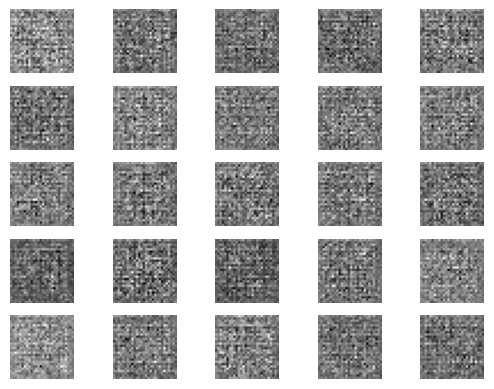

In [20]:
n_samples = 25
X, _ = generate_fake_samples(model_g, latent_dim, n_samples)

# latent space의 어떤 data point(gaussian noise)로부터 생성해 낸 28x28 이미지
for i in range(n_samples):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
pyplot.show()

# 당연하게도 MNIST와 하나도 유사하지 않은 28x28 이미지들을 생성함
# Generator model은 아직 훈련을 진행하지 않았음

# 4. Train the Generator Model

The weights in the Generator model are updated based on the performance of the Discriminator model.  

CASE 1. Generator model is **updated more** <- when the Discriminator is good at detecting fake samples.  
CASE 2. Generator mode is **updated less** <- when the Discriminator is relatively poor or confused when detecting fake samples.

In [21]:
def define_gan(g_model, d_model):
    # Discriminator는 위 과정에서 이미 어느정도 훈련을 했음.
    # 더 훈련하면 mode collapse의 위험이 있기 때문에 freeze 시킴.
    # (당연하게도) Generator는 Discriminator를 더 잘 속일 수 있는 방향으로 updated될 것임.
    d_model.trainable = False
    model = Sequential(name='GAN')
    model.add(g_model) # Generator가 생성해 낸 이미지를
    model.add(d_model) # Discriminator가 real or fake 여부를 구분
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)

    return model

In [22]:
model_gan = define_gan(model_g, model_d)
model_gan.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 28, 28, 1)         1164289   
                                                                 
 Discriminator (Sequential)  (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


In [23]:
# train the GAN model
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

# Generator의 목적은 real 같은 fake를 만드는 것.
# 즉 Discriminator가 fake라고 판별한다면, Generator에게 "더 잘 만들어 봐."하고 패널티를 줘야 됨.
# 이를 loss function으로 구현하기 위해서는 Generator가 만들어 낸 image의 label을 1로 설정해야 됨.
# Discriminator가 초반에는 Generator가 만들어 낸 image를 fake(0)라고 분류할 것인데,
# 이때 image의 label이 real(1)이라고 되어 있으므로 loss 값이 크게 측정되고,
# Generator는 이 loss 값을 줄이기 위해 Discriminator가 real(1)이라고 분류할 정도로 정교할 image를
# 만들어 내는 방향으로 훈련될 것임.

In [24]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=512):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 1 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [27]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

In [28]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

8/8 [==============================] - 0s 4ms/step
>1, 1/117, d=0.007, g=6.334
8/8 [==============================] - 0s 4ms/step
>1, 2/117, d=0.006, g=6.221
8/8 [==============================] - 0s 4ms/step
>1, 3/117, d=0.007, g=6.179
8/8 [==============================] - 0s 4ms/step
>1, 4/117, d=0.006, g=6.016
8/8 [==============================] - 0s 4ms/step
>1, 5/117, d=0.007, g=5.961
8/8 [==============================] - 0s 4ms/step
>1, 6/117, d=0.007, g=5.784
8/8 [==============================] - 0s 4ms/step
>1, 7/117, d=0.007, g=5.531
8/8 [==============================] - 0s 4ms/step
>1, 8/117, d=0.008, g=5.231
8/8 [==============================] - 0s 4ms/step
>1, 9/117, d=0.009, g=4.778
8/8 [==============================] - 0s 4ms/step
>1, 10/117, d=0.013, g=4.104
8/8 [==============================] - 0s 4ms/step
>1, 11/117, d=0.024, g=3.428
8/8 [==============================] - 0s 4ms/step
>1, 12/117, d=0.054, g=2.564
8/8 [==============================] - 0s 4ms/ste

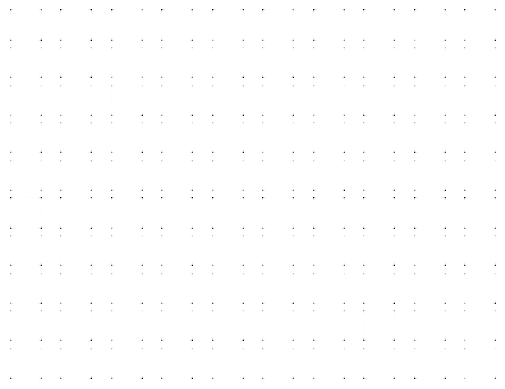

8/8 [==============================] - 0s 10ms/step
>2, 1/117, d=0.033, g=3.255
8/8 [==============================] - 0s 4ms/step
>2, 2/117, d=0.032, g=3.265
8/8 [==============================] - 0s 4ms/step
>2, 3/117, d=0.028, g=3.276
8/8 [==============================] - 0s 4ms/step
>2, 4/117, d=0.029, g=3.298
8/8 [==============================] - 0s 4ms/step
>2, 5/117, d=0.027, g=3.325
8/8 [==============================] - 0s 4ms/step
>2, 6/117, d=0.031, g=3.360
8/8 [==============================] - 0s 4ms/step
>2, 7/117, d=0.027, g=3.327
8/8 [==============================] - 0s 4ms/step
>2, 8/117, d=0.027, g=3.389
8/8 [==============================] - 0s 4ms/step
>2, 9/117, d=0.026, g=3.418
8/8 [==============================] - 0s 4ms/step
>2, 10/117, d=0.032, g=3.412
8/8 [==============================] - 0s 4ms/step
>2, 11/117, d=0.024, g=3.436
8/8 [==============================] - 0s 4ms/step
>2, 12/117, d=0.032, g=3.439
8/8 [==============================] - 0s 4ms/st

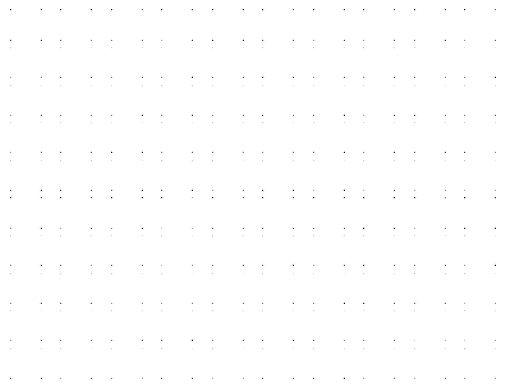

8/8 [==============================] - 0s 4ms/step
>3, 1/117, d=0.010, g=4.413
8/8 [==============================] - 0s 5ms/step
>3, 2/117, d=0.010, g=4.456
8/8 [==============================] - 0s 4ms/step
>3, 3/117, d=0.010, g=4.461
8/8 [==============================] - 0s 4ms/step
>3, 4/117, d=0.010, g=4.451
8/8 [==============================] - 0s 4ms/step
>3, 5/117, d=0.008, g=4.450
8/8 [==============================] - 0s 4ms/step
>3, 6/117, d=0.010, g=4.493
8/8 [==============================] - 0s 4ms/step
>3, 7/117, d=0.011, g=4.490
8/8 [==============================] - 0s 4ms/step
>3, 8/117, d=0.013, g=4.498
8/8 [==============================] - 0s 4ms/step
>3, 9/117, d=0.011, g=4.466
8/8 [==============================] - 0s 4ms/step
>3, 10/117, d=0.012, g=4.467
8/8 [==============================] - 0s 4ms/step
>3, 11/117, d=0.012, g=4.482
8/8 [==============================] - 0s 4ms/step
>3, 12/117, d=0.014, g=4.451
8/8 [==============================] - 0s 4ms/ste

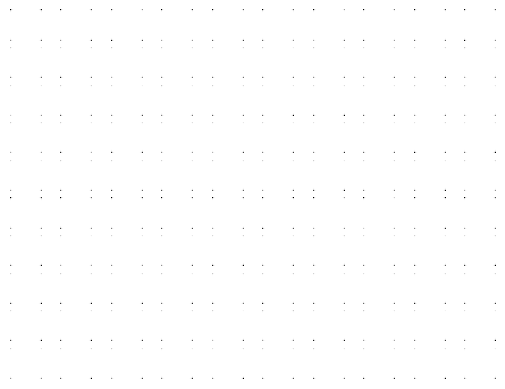

8/8 [==============================] - 0s 4ms/step
>4, 1/117, d=0.005, g=5.055
8/8 [==============================] - 0s 4ms/step
>4, 2/117, d=0.009, g=5.050
8/8 [==============================] - 0s 4ms/step
>4, 3/117, d=0.008, g=5.022
8/8 [==============================] - 0s 4ms/step
>4, 4/117, d=0.005, g=5.069
8/8 [==============================] - 0s 4ms/step
>4, 5/117, d=0.007, g=5.059
8/8 [==============================] - 0s 4ms/step
>4, 6/117, d=0.005, g=5.059
8/8 [==============================] - 0s 4ms/step
>4, 7/117, d=0.006, g=5.057
8/8 [==============================] - 0s 4ms/step
>4, 8/117, d=0.004, g=5.097
8/8 [==============================] - 0s 4ms/step
>4, 9/117, d=0.005, g=5.110
8/8 [==============================] - 0s 4ms/step
>4, 10/117, d=0.004, g=5.124
8/8 [==============================] - 0s 4ms/step
>4, 11/117, d=0.007, g=5.064
8/8 [==============================] - 0s 4ms/step
>4, 12/117, d=0.007, g=5.111
8/8 [==============================] - 0s 4ms/ste

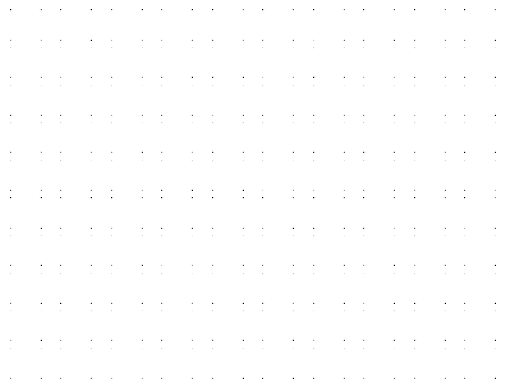

8/8 [==============================] - 0s 5ms/step
>5, 1/117, d=0.004, g=5.663
8/8 [==============================] - 0s 4ms/step
>5, 2/117, d=0.003, g=5.635
8/8 [==============================] - 0s 4ms/step
>5, 3/117, d=0.003, g=5.616
8/8 [==============================] - 0s 5ms/step
>5, 4/117, d=0.005, g=5.629
8/8 [==============================] - 0s 4ms/step
>5, 5/117, d=0.004, g=5.651
8/8 [==============================] - 0s 4ms/step
>5, 6/117, d=0.003, g=5.616
8/8 [==============================] - 0s 4ms/step
>5, 7/117, d=0.002, g=5.630
8/8 [==============================] - 0s 4ms/step
>5, 8/117, d=0.002, g=5.647
8/8 [==============================] - 0s 4ms/step
>5, 9/117, d=0.003, g=5.614
8/8 [==============================] - 0s 4ms/step
>5, 10/117, d=0.003, g=5.585
8/8 [==============================] - 0s 4ms/step
>5, 11/117, d=0.003, g=5.654
8/8 [==============================] - 0s 4ms/step
>5, 12/117, d=0.003, g=5.658
8/8 [==============================] - 0s 4ms/ste

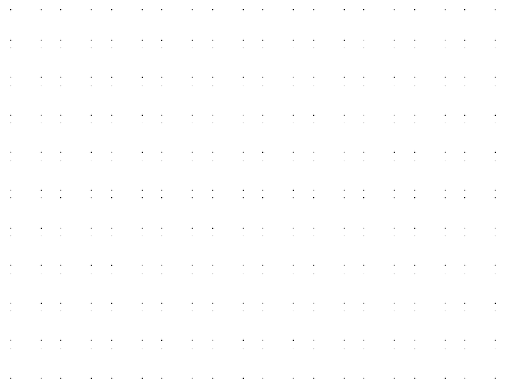

8/8 [==============================] - 0s 5ms/step
>6, 1/117, d=0.004, g=5.869
8/8 [==============================] - 0s 4ms/step
>6, 2/117, d=0.002, g=5.867
8/8 [==============================] - 0s 4ms/step
>6, 3/117, d=0.003, g=5.910
8/8 [==============================] - 0s 4ms/step
>6, 4/117, d=0.002, g=5.860
8/8 [==============================] - 0s 4ms/step
>6, 5/117, d=0.003, g=5.857
8/8 [==============================] - 0s 4ms/step
>6, 6/117, d=0.003, g=5.891
8/8 [==============================] - 0s 4ms/step
>6, 7/117, d=0.002, g=5.899
8/8 [==============================] - 0s 4ms/step
>6, 8/117, d=0.002, g=5.896
8/8 [==============================] - 0s 4ms/step
>6, 9/117, d=0.002, g=5.910
8/8 [==============================] - 0s 4ms/step
>6, 10/117, d=0.002, g=5.941
8/8 [==============================] - 0s 4ms/step
>6, 11/117, d=0.002, g=5.941
8/8 [==============================] - 0s 4ms/step
>6, 12/117, d=0.002, g=5.979
8/8 [==============================] - 0s 4ms/ste

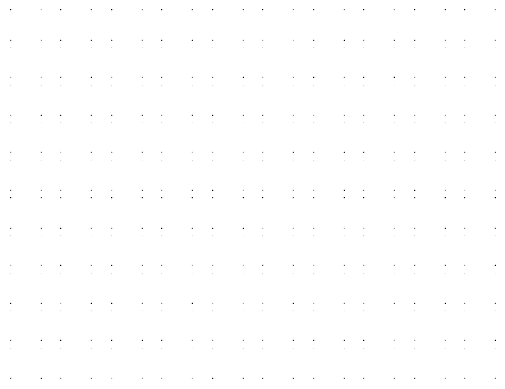

8/8 [==============================] - 0s 5ms/step
>7, 1/117, d=0.002, g=6.333
8/8 [==============================] - 0s 5ms/step
>7, 2/117, d=0.002, g=6.342
8/8 [==============================] - 0s 4ms/step
>7, 3/117, d=0.002, g=6.320
8/8 [==============================] - 0s 5ms/step
>7, 4/117, d=0.002, g=6.376
8/8 [==============================] - 0s 4ms/step
>7, 5/117, d=0.001, g=6.362
8/8 [==============================] - 0s 4ms/step
>7, 6/117, d=0.003, g=6.337
8/8 [==============================] - 0s 4ms/step
>7, 7/117, d=0.001, g=6.358
8/8 [==============================] - 0s 4ms/step
>7, 8/117, d=0.001, g=6.358
8/8 [==============================] - 0s 4ms/step
>7, 9/117, d=0.001, g=6.397
8/8 [==============================] - 0s 4ms/step
>7, 10/117, d=0.005, g=6.331
8/8 [==============================] - 0s 4ms/step
>7, 11/117, d=0.002, g=6.310
8/8 [==============================] - 0s 4ms/step
>7, 12/117, d=0.001, g=6.364
8/8 [==============================] - 0s 5ms/ste

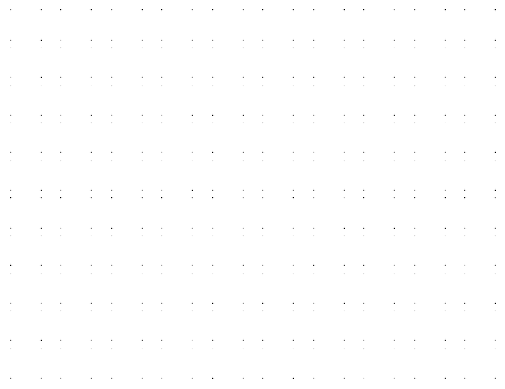

8/8 [==============================] - 0s 14ms/step
>8, 1/117, d=0.001, g=6.632
8/8 [==============================] - 0s 5ms/step
>8, 2/117, d=0.001, g=6.701
8/8 [==============================] - 0s 5ms/step
>8, 3/117, d=0.002, g=6.687
8/8 [==============================] - 0s 5ms/step
>8, 4/117, d=0.001, g=6.693
8/8 [==============================] - 0s 5ms/step
>8, 5/117, d=0.001, g=6.702
8/8 [==============================] - 0s 5ms/step
>8, 6/117, d=0.002, g=6.698
8/8 [==============================] - 0s 5ms/step
>8, 7/117, d=0.002, g=6.642
8/8 [==============================] - 0s 4ms/step
>8, 8/117, d=0.002, g=6.676
8/8 [==============================] - 0s 4ms/step
>8, 9/117, d=0.002, g=6.667
8/8 [==============================] - 0s 4ms/step
>8, 10/117, d=0.001, g=6.631
8/8 [==============================] - 0s 4ms/step
>8, 11/117, d=0.002, g=6.667
8/8 [==============================] - 0s 4ms/step
>8, 12/117, d=0.004, g=6.675
8/8 [==============================] - 0s 4ms/st

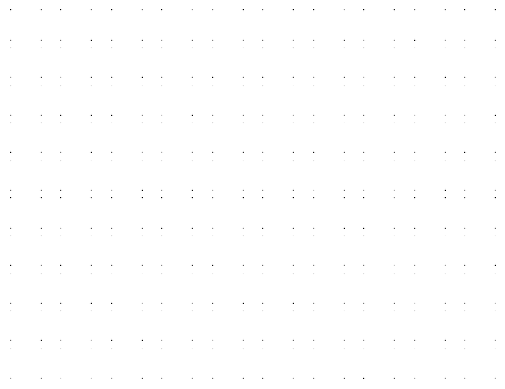

8/8 [==============================] - 0s 14ms/step
>9, 1/117, d=0.001, g=6.811
8/8 [==============================] - 0s 4ms/step
>9, 2/117, d=0.001, g=6.746
8/8 [==============================] - 0s 4ms/step
>9, 3/117, d=0.001, g=6.787
8/8 [==============================] - 0s 4ms/step
>9, 4/117, d=0.001, g=6.801
8/8 [==============================] - 0s 4ms/step
>9, 5/117, d=0.001, g=6.847
8/8 [==============================] - 0s 4ms/step
>9, 6/117, d=0.002, g=6.852
8/8 [==============================] - 0s 4ms/step
>9, 7/117, d=0.002, g=6.816
8/8 [==============================] - 0s 4ms/step
>9, 8/117, d=0.001, g=6.840
8/8 [==============================] - 0s 4ms/step
>9, 9/117, d=0.001, g=6.793
8/8 [==============================] - 0s 4ms/step
>9, 10/117, d=0.002, g=6.785
8/8 [==============================] - 0s 4ms/step
>9, 11/117, d=0.001, g=6.823
8/8 [==============================] - 0s 4ms/step
>9, 12/117, d=0.001, g=6.837
8/8 [==============================] - 0s 4ms/st

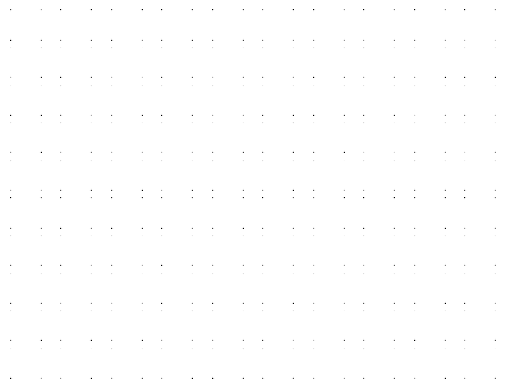

8/8 [==============================] - 0s 4ms/step
>10, 1/117, d=0.001, g=7.045
8/8 [==============================] - 0s 4ms/step
>10, 2/117, d=0.001, g=7.072
8/8 [==============================] - 0s 4ms/step
>10, 3/117, d=0.001, g=7.106
8/8 [==============================] - 0s 4ms/step
>10, 4/117, d=0.001, g=7.084
8/8 [==============================] - 0s 4ms/step
>10, 5/117, d=0.001, g=7.111
8/8 [==============================] - 0s 4ms/step
>10, 6/117, d=0.001, g=7.078
8/8 [==============================] - 0s 4ms/step
>10, 7/117, d=0.001, g=7.023
8/8 [==============================] - 0s 4ms/step
>10, 8/117, d=0.001, g=7.125
8/8 [==============================] - 0s 4ms/step
>10, 9/117, d=0.003, g=7.066
8/8 [==============================] - 0s 4ms/step
>10, 10/117, d=0.001, g=7.043
8/8 [==============================] - 0s 4ms/step
>10, 11/117, d=0.001, g=7.067
8/8 [==============================] - 0s 4ms/step
>10, 12/117, d=0.001, g=7.046
8/8 [==============================] 

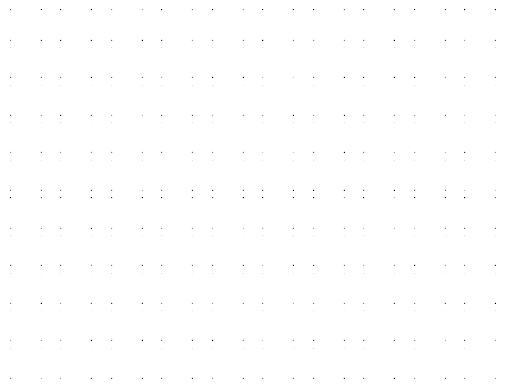

In [29]:
train(model_g, model_d, model_gan, dataset, latent_dim)